Mention the base path containing the folders of results and initialize a dataframe to combine the data across papers

In [19]:
import os
import pandas as pd
import glob
import re

# Step 1: Define the base path
base_path = r".\final_query_set1_dois_results_dec_ver_all"

# Step 2: Use glob to find all CSV files in the subdirectories
file_pattern = os.path.join(base_path, "**", "article_results_*_final.csv")
csv_files = glob.glob(file_pattern, recursive=True)
print(len(csv_files))
# Step 3: Initialize an empty DataFrame to hold the combined data
combined_df = pd.DataFrame()

10829


Dictionary that maps processing condition and function that standardizes processing condition

In [20]:
# Step 4: Create a dictionary for processing condition classification
condition_mapping = {
    "cast": "AC",
    "melt": "AC",
    "splat quench": "SQ",
    "quench": "SQ",
    "induction furnace": "AC",
    "arc melt": "AC",
    "arc": "AC",
    "argon atmosphere": "AC",
    "sputtering": "SP",
    "sputter deposition": "SP",
    "sputtered": "SP",
    "mechanical alloying and spark plasma sintering": "MA+SPS",
    "mechanical alloying": "MA+SPS",
    "mechanically alloyed": "MA+SPS",
    "spark plasma sintering": "MA+SPS",
    "spark plasma sintered": "MA+SPS",
    "mechanically alloyed, sps": "MA+SPS",
    "forged": "FOR",
    "vacuum hot pressed": "VHP",
    "rolled at room temperature": "CR",
    "rolling at room temperature": "CR",
    "cold rolled": "CR",
    "hot isostatically pressed": "HIP",
    "hot isostatic pressing": "HIP",
    "hot forging, cold rolling": "FOR+CR",
    "annealed": "AC",
    "annealing": "AC",
}

# Helper function to standardize processing conditions
def standardize_processing_condition(condition, mapping):
    condition = condition.lower()
    for key, value in mapping.items():
        if key in condition:
            return value
    return condition  # Return the original condition if no match is found

# Helper function to remove full stops at the end of alloy names
def remove_trailing_fullstop(alloy_name):
    return alloy_name.rstrip('.')

Loop through the found CSV files and concatenate them after standardizing

In [21]:
# Step 5: Loop through the found CSV files and concatenate them
for file in csv_files:
    df = pd.read_csv(file)
    
    # Check if the required columns exist
    if 'Alloy name' not in df.columns or 'Processing conditions' not in df.columns:
        print(f"File {file} is missing required columns.")
        continue
    
    # Remove full stops from alloy names
    df['Alloy name'] = df['Alloy name'].apply(remove_trailing_fullstop)
    
    # Standardize the 'Processing conditions' column using the dictionary
    df['Mapped Processing conditions'] = df['Processing conditions'].apply(standardize_processing_condition, args=(condition_mapping,))
    
    # Extract the folder name (DOI) from the file path and add it as a new column
    doi = os.path.basename(os.path.dirname(file))
    df['DOI'] = doi
    combined_df = pd.concat([combined_df, df], ignore_index=True)

combined_df.head(10)

,Alloy name,Processing conditions,Characterization techniques,Properties,Mapped Processing conditions,DOI
0,CrTe1.590,-,DSC,"Heat Capacity, Transition Entropy",-,10.1016.0022-3115(93)90166-V
1,CrTe1.609,-,DSC,"Heat Capacity, Transition Entropy",-,10.1016.0022-3115(93)90166-V
2,CrTe1.528,-,DSC,"Heat Capacity, Transition Entropy",-,10.1016.0022-3115(93)90166-V
3,CrTe1.576,-,DSC,"Heat Capacity, Transition Entropy",-,10.1016.0022-3115(93)90166-V
4,Cr2Zr,-,-,-,-,10.1016.0022-3115(93)90184-Z
5,Fe2Zr,-,-,"Thermodynamic Activity, Enthalpy, Entropy, Gib...",-,10.1016.0022-3115(93)90184-Z
6,Zr41.2Ti13.8Cu12.5Ni10Be22.5,-,-,-,-,10.1016.0168-583X(96)00218-2
7,Pt90Rh10,-,-,Segregation,-,10.1016.0169-4332(95)00525-0
8,Ni52Ti48,-,DSC,"Heat Capacity, Phase Transformation, Chemical ...",-,10.1016.0921-5093(91)90792-L
9,Zr0.6Ho0.4Co2,-,-,"Density, Hydrogen concentration, Unit cell vol...",-,10.1016.0925-8388(93)90278-U


Multiple paragraphs in the same article may talk about the same alloy. Alloy composition+ processing condition is an alloy identifier. If processing condition is '-' that usually means that the alloy is talked about elsewhere in the paper. First, we make changes to these PCs.

In [34]:
# Step 6: Replace '-' in processing conditions with the corresponding condition for the same alloy name
def replace_hyphens(group):
    non_hyphen_conditions = group['Processing conditions'][group['Processing conditions'] != '-']
    non_hyphen_conditions1 = group['Mapped Processing conditions'][group['Mapped Processing conditions'] != '-']
    if not non_hyphen_conditions.empty:
        condition_to_replace = non_hyphen_conditions.iloc[0]
        condition_to_replace1 = non_hyphen_conditions1.iloc[0]
        group['Processing conditions'] = group['Processing conditions'].replace('-', condition_to_replace)
        group['Mapped Processing conditions'] = group['Mapped Processing conditions'].replace('-', condition_to_replace1)
    return group

# Rename 'Alloy name' temporarily to avoid ambiguity
combined_df.rename(columns={'Alloy name': 'Alloy Name Temp'}, inplace=True)

# Apply the groupby and replacement
combined_df = combined_df.groupby('Alloy Name Temp').apply(replace_hyphens)

# Rename 'Alloy Name Temp' back to 'Alloy name'
combined_df.rename(columns={'Alloy Name Temp': 'Alloy name'}, inplace=True)


In [35]:
combined_df.head()

,Alloy name,Processed Alloy Name,Type,Conventional,Processing conditions,Mapped Processing conditions,Characterization techniques,Properties,DOI,DOI Number,Normalized Alloy Composition
42497,Nb19.75Mo19.75Ta19.75W19.75V20.75,Mo19.75Nb19.75Ta19.75V20.75W19.75,alloy,conventional,Sputter deposition,SP,-,"Hardness, Thermal Stability, Wear-resistance",10.1016.j.apsusc.2021.150462,[1],Mo0.20Nb0.20Ta0.20V0.21W0.20
42496,Nb19.75Mo19.75Ta19.75W19.75V20.75,Mo19.75Nb19.75Ta19.75V20.75W19.75,alloy,conventional,Sputter deposition,SP,"AFM, EDS, EPMA, GIXRD, HRTEM, SEM, TEM, WDS, X...","Elastic Modulus, Hardness, Resistivity",10.1016.j.apsusc.2021.150462,[1],Mo0.20Nb0.20Ta0.20V0.21W0.20
42557,Nb21.35Mo21.35Ta21.35W21.35V14.6,Mo21.35Nb21.35Ta21.35V14.6W21.35,alloy,conventional,Sputter deposition,SP,"AFM, EDS, EPMA, GIXRD, HRTEM, SEM, TEM, WDS, X...","Elasticity Modulus, Hardness, Resistivity",10.1016.j.apsusc.2021.150462,[1],Mo0.21Nb0.21Ta0.21V0.15W0.21
42558,Nb21.35Mo21.35Ta21.35W21.35V14.6,Mo21.35Nb21.35Ta21.35V14.6W21.35,alloy,conventional,Sputter deposition,SP,-,"Hardness, Thermal Stability, Wear-resistance",10.1016.j.apsusc.2021.150462,[1],Mo0.21Nb0.21Ta0.21V0.15W0.21
42561,Nb22.95Mo22.95Ta22.95W22.95V8.15,Mo22.95Nb22.95Ta22.95V8.15W22.95,alloy,conventional,Sputter deposition,SP,"AFM, EDS, EPMA, GIXRD, HRTEM, SEM, TEM, WDS, X...","Elasticity Modulus, Hardness, Resistivity",10.1016.j.apsusc.2021.150462,[1],Mo0.23Nb0.23Ta0.23V0.08W0.23


Clean and concatenate combines redundant records which talk about the same identifier

In [36]:
# Step 7: Clean and concatenate Characterization techniques and properties columns
def clean_and_concatenate_columns(group):
    # Helper function to clean a column
    def clean_column(column):
        if column.dtype == 'object':  # Check if the column contains strings
            items = column.str.cat(sep=', ').split(', ')
            cleaned_items = sorted(set(item.strip() for item in items if item and item != '-'))
            return ', '.join(cleaned_items) if cleaned_items else '-'
        return '-'

    # Apply cleaning to the relevant columns
    cleaned_characterization = clean_column(group['Characterization techniques'])
    cleaned_properties = clean_column(group['Properties'])

    # Rename 'Alloy name' temporarily to avoid ambiguity
    return pd.Series({
        'Alloy Name Temp': group['Alloy name'].iloc[0],  # Temporary name
        'Processing conditions': group['Processing conditions'].iloc[0],
        'Mapped Processing conditions': group['Mapped Processing conditions'].iloc[0],
        'Characterization techniques': cleaned_characterization,
        'Properties': cleaned_properties,
        'DOI': group['DOI'].iloc[0],
    })

# Apply groupby and clean each group
grouped = combined_df.groupby(['Alloy name', 'Mapped Processing conditions', 'DOI'])
cleaned_groups = grouped.apply(clean_and_concatenate_columns)

# Reset the index to ensure no index levels are carried over
final_df = cleaned_groups.reset_index(drop=True)

# Rename 'Alloy Name Temp' back to 'Alloy name'
final_df.rename(columns={'Alloy Name Temp': 'Alloy name'}, inplace=True)


In [37]:
final_df.head(25)

,Alloy name,Processing conditions,Mapped Processing conditions,Characterization techniques,Properties,DOI
0,(5Ce0.2)Ta3O9,Conventional sintering in air at 1500 C for 10 h,conventional sintering in air at 1500 c for 10 h,-,"Fracture Toughness, Orthogonal Structure, Slug...",10.1016.j.ceramint.2021.12.332
1,(5Ce0.2)Ta3O9,Conventional sintering in air at 1500 C for 10 h,conventional sintering in air at 1500 c for 10 h,"DSC, EDS, HRTEM, SEM, TG, Vickers, XRD","Fracture Toughness, Hardness, Porosity, Specif...",10.1016.j.ceramint.2021.12.332
2,(5Eu0.2)Ta3O9,Conventional sintering in air at 1500 C for 10 h,conventional sintering in air at 1500 c for 10 h,-,"Fracture Toughness, Orthogonal Structure, Slug...",10.1016.j.ceramint.2021.12.332
3,(5Eu0.2)Ta3O9,Conventional sintering in air at 1500 C for 10 h,conventional sintering in air at 1500 c for 10 h,"DSC, EDS, HRTEM, SEM, TG, Vickers, XRD","Fracture Toughness, Hardness, Porosity, Specif...",10.1016.j.ceramint.2021.12.332
4,(5Gd0.2)Ta3O9,Conventional sintering in air at 1500 C for 10 h,conventional sintering in air at 1500 c for 10 h,-,"Fracture Toughness, Orthogonal Structure, Slug...",10.1016.j.ceramint.2021.12.332
5,(5Gd0.2)Ta3O9,Conventional sintering in air at 1500 C for 10 h,conventional sintering in air at 1500 c for 10 h,"DSC, EDS, HRTEM, SEM, TG, Vickers, XRD","Bulk density, Fracture Toughness, Hardness, Po...",10.1016.j.ceramint.2021.12.332
6,(5La0.2)Ta3O9,Conventional sintering in air at 1500 C for 10 h,conventional sintering in air at 1500 c for 10 h,-,"Fracture Toughness, Thermal Conductivity, Ther...",10.1016.j.ceramint.2021.12.332
7,(5La0.2)Ta3O9,Conventional sintering in air at 1500 C for 10 h,conventional sintering in air at 1500 c for 10 h,"DSC, EDS, HRTEM, SEM, TG, Vickers, XRD","Fracture Toughness, Hardness, Porosity, Specif...",10.1016.j.ceramint.2021.12.332
8,(5Nd0.2)Ta3O9,Conventional sintering in air at 1500 C for 10 h,conventional sintering in air at 1500 c for 10 h,"DSC, EDS, HRTEM, SEM, TG, Vickers, XRD","Fracture Toughness, Hardness, Orthogonal Struc...",10.1016.j.ceramint.2021.12.332
9,(5Nd0.2)Ta3O9,Conventional sintering in air at 1500 C for 10 h,conventional sintering in air at 1500 c for 10 h,-,-,10.1016.j.ceramint.2021.12.332


Sort the alloy names

In [38]:
# Step 8: Sort alloy names alphabetically
# def sort_alloy_name(alloy_name):
#     elements = re.findall(r'[A-Z][a-z]?\d*\.?\d*', alloy_name)
#     sorted_elements = sorted(elements, key=lambda x: re.sub(r'\d', '', x))
#     return ''.join(sorted_elements)

# final_df['Alloy name'] = final_df['Alloy name'].apply(sort_alloy_name)


# List of all non-radioactive elements from the periodic table
NON_RADIOACTIVE_ELEMENTS = [
    'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 
    'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 
    'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 
    'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 
    'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 
    'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U'
]

def process_alloy_name(alloy_name):
    # Extract elements from the alloy name
    elements = re.findall(r'[A-Z][a-z]?\d*\.?\d*', alloy_name)
    valid_elements = [re.sub(r'\d*\.?\d*', '', el) for el in elements]
    
    # Check if all extracted elements are valid
    is_conventional = all(el in NON_RADIOACTIVE_ELEMENTS for el in valid_elements)
    
    # If the original alloy name doesn't fully match extracted parts, it's unconventional
    reconstructed_name = ''.join(elements)
    if reconstructed_name != alloy_name:
        is_conventional = False
    
    if not is_conventional:
        processed_name = alloy_name  # Keep original name
        classification = 'alloy'
        unconventional = 'unconventional'
    else:
        # Sort elements and classify as element or alloy
        sorted_elements = sorted(elements, key=lambda x: re.sub(r'\d', '', x))
        processed_name = ''.join(sorted_elements)
        classification = 'element' if len(valid_elements) == 1 else 'alloy'
        unconventional = 'conventional'
    
    return processed_name, classification, unconventional

# Apply the function to the DataFrame
def update_dataframe(df):
    processed_data = df['Alloy name'].apply(process_alloy_name)
    df['Processed Alloy Name'] = processed_data.map(lambda x: x[0])
    df['Type'] = processed_data.map(lambda x: x[1])
    df['Conventional'] = processed_data.map(lambda x: x[2])
    return df

# Example usage
# data = {
#     'Alloy name': ['Al10Cr5', 'Fe', '(Al,Cr,Nb,Si,Ti,V)50-xN50', 'Alias123']
# }
# final_df = pd.DataFrame(data)
final_df = update_dataframe(final_df)

print(final_df.head(25))

                        Alloy name  \
0                    (5Ce0.2)Ta3O9   
1                    (5Ce0.2)Ta3O9   
2                    (5Eu0.2)Ta3O9   
3                    (5Eu0.2)Ta3O9   
4                    (5Gd0.2)Ta3O9   
5                    (5Gd0.2)Ta3O9   
6                    (5La0.2)Ta3O9   
7                    (5La0.2)Ta3O9   
8                    (5Nd0.2)Ta3O9   
9                    (5Nd0.2)Ta3O9   
10                  (5RE0.2)2Si2O7   
11                  (5RE0.2)2Si2O7   
12                  (5RE0.2)2Si2O7   
13                   (5RE0.2)Ta3O9   
14                   (5RE0.2)Ta3O9   
15                   (5Sm0.2)Ta3O9   
16                   (5Sm0.2)Ta3O9   
17                  (8RE1/8)2Si2O7   
18  (Ag0.95Nb0.05BiSe2)0.8(PbS)0.2   
19  (Ag0.97Nb0.03BiSe2)0.8(PbS)0.2   
20  (Ag0.99Nb0.01BiSe2)0.8(PbS)0.2   
21           (AgBiSe2)0.7(SnTe)0.3   
22            (AgBiSe2)0.8(PbS)0.2   
23                             (Al   
24                             (Al   

           

Property mapping

In [39]:

property_mapping = {
    'corrosion': 'C',
    'corrosion resistance': 'C',
    'anti-oxidation': 'C',
    'oxidation': 'OX',
    'coefficient of thermal expansion': 'CTE',
    'density': 'D',
    'differential scanning calorimetry': 'DSC',
    'hardness': 'H',
    'hydrogen adsorption/desorption': 'HY',
    'mechanical': 'M',
    'strength': 'M',
    'mechanical (tensile)': 'MT',
    'ductility': 'MT',
    'brittle': 'MT',
    'elongation': 'MT',
    'magnetic': 'MAG',
    'magnetic permeability': 'MAG',
    'electrical resistivity': 'R',
    "electrical conductivity": "R",
    'phonons': 'VIB',
    "phonon":"VIB",
    'wear': 'W',
    "work-hardening":"M",
    "yield":"M",
    "fatigue":"M",
    "uts":"MT",
    "workability":"M",
    "magnetostriction":"MAG",
    "yield Stress":"MT",
    "heat capacity":"DSC",
    "thermal diffusivity":"DSC",
    "thermal conductivity":"DSC",
    "elastic modulus":"MT",
    "hydrogen storage":"HY",
    "tensile properties":"MT",
    "microhardness":"H",
    "vickers":"H",
    "vicker's":"H",
    "toughness":"MT",
}

def map_properties(properties):
    mapped = [property_mapping.get(prop.lower(), prop) for prop in properties.split(', ')]
    return ', '.join(sorted(set(mapped))) if mapped else '-'

# final_df['Mapped property'] = final_df['Properties'].apply(map_properties)

# Step 9: Map DOI to unique numbers and reorder columns
doi_mapping = {doi: idx + 1 for idx, doi in enumerate(final_df['DOI'].unique())}
# doi_mapping={}
# for i in final_dict:
#     ref_number=int(i[1:len(i)-1])
#     doi_mapping[final_dict[i]]=ref_number
#     print(ref_number, final_dict[i])
# print(doi_mapping)
final_df['DOI Number'] = final_df['DOI'].map(doi_mapping).apply(lambda x: f"[{x}]")
final_df = final_df[['Alloy name', 'Processed Alloy Name','Type','Conventional','Processing conditions','Mapped Processing conditions' ,'Characterization techniques', 'Properties', 'DOI', 'DOI Number']]

# Save the result
output_file = os.path.join(base_path, "combined_results_with_doi.csv")
final_df.to_csv(output_file, index=False)
print(f"Combined CSV file saved to: {output_file}")

Combined CSV file saved to: .\final_query_set1_dois_results_dec_ver_all\combined_results_with_doi.csv


Counting unique alloy compositions

In [40]:
import pandas as pd
import re

# Load the HEAsTable.csv and combined_results_with_doi.csv files
combined_file = r".\final_query_set1_dois_results_dec_ver_all\combined_results_with_doi.csv"

combined_df = pd.read_csv(combined_file)

# Function to normalize the alloy compositions
def normalize_alloy_composition(alloy_name):
    if not isinstance(alloy_name, str):
        return alloy_name
    
    # Regular expression to match elements with optional decimal numbers
    elements_with_numbers = re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', alloy_name)
    
    composition_dict = {}
    total_value = 0
    max_value = 0  # To track the maximum number
    
    # Parse the element and its associated number
    for element, number in elements_with_numbers:
        if number == '':  # If no number is given, assign 1 for now (will adjust later)
            number = 1.0
        else:
            number = float(number)
        
        composition_dict[element] = number
        total_value += number
        
        if number > max_value:
            max_value = number  # Track the largest number
    
    # Check if any number is greater than 10; if so, adjust missing numbers to 100
    for element in composition_dict:
        if composition_dict[element] == 1.0 and max_value > 10:
            composition_dict[element] = 100.0  # Set to 100 if max number > 10
    
    # Recalculate the total value after adjustment
    total_value = sum(composition_dict.values())
    
    # Scale numbers so their sum equals 1
    try:
        scaling_factor = 1 / total_value
    except: 
        scaling_factor=total_value
    # Apply scaling factor and create the standardized composition string
    standardized_elements = []
    for element, number in sorted(composition_dict.items()):
        scaled_number = number * scaling_factor
        standardized_elements.append(f'{element}{scaled_number:.2f}')  # rounded to 2 decimal places
    
    # Join the elements back into a single string
    return ''.join(standardized_elements)

# Step 1: Normalize the alloy names in both datasets and add as new columns
combined_df['Normalized Alloy Composition'] = combined_df['Alloy name'].apply(normalize_alloy_composition)

# Step 2: Get unique alloy compositions in HEAsTable and combined_results_with_doi
unique_alloys_combined = set(combined_df['Normalized Alloy Composition'].unique())

# Step 4: Output the result
print(f"Total unique alloys in combined_results_with_doi: {len(unique_alloys_combined)}")

# Save the updatedcombined_results_with_doi with new columns
combined_df_file = r".\final_query_set1_dois_results_dec_ver_all\combined_results_with_doi_normalized.csv"
combined_df.to_csv(combined_df_file, index=False)

print(f"Updated combined_results_with_doi saved to: {combined_df_file}")

Total unique alloys in combined_results_with_doi: 14091
Updated combined_results_with_doi saved to: .\final_query_set1_dois_results_dec_ver_all\combined_results_with_doi_normalized.csv


Sorting records by DOI

In [41]:
import pandas as pd
import re

# File path for combined dataset
combined_file = r".\final_query_set1_dois_results_dec_ver_all\combined_results_with_doi_normalized.csv"
sorted_combined_file = r".\final_query_set1_dois_results_dec_ver_all\sorted_combined_results_with_doi.csv"

# Load the combined dataset
combined_df = pd.read_csv(combined_file)

# Function to extract DOI number from string format '[DOI Number]'
def extract_doi_number(doi_string):
    match = re.search(r'\[(\d+)\]', str(doi_string))
    if match:
        return int(match.group(1))  # Extract the numeric part inside the brackets
    return None  # Return None if DOI number is not found

# Function to convert DOI number back into string format '[DOI Number]'
def format_doi_number(doi_number):
    return f'[{doi_number}]'

# Process the combined dataset
combined_df['DOI Number'] = combined_df['DOI Number'].apply(extract_doi_number)  # Assuming 'DOI' is the column name
combined_df = combined_df.sort_values(by='DOI Number')  # Sort by the extracted DOI number
combined_df['DOI Number'] = combined_df['DOI Number'].apply(format_doi_number)  # Convert back to original format
# combined_df = combined_df.drop(columns=['DOI Number'])  # Drop the temporary sorting column

# Save the sorted combined dataset to a new file
combined_df.to_csv(sorted_combined_file, index=False)

print(f"Sorted combined dataset saved to: {sorted_combined_file}")

Sorted combined dataset saved to: .\final_query_set1_dois_results_dec_ver_all\sorted_combined_results_with_doi.csv


Cleaning records

In [43]:
import pandas as pd
import re
import unicodedata
from unidecode import unidecode
# Define the file path
file_path = r".\final_query_set1_dois_results_dec_ver_all\sorted_combined_results_with_doi.csv"

# Function to clean and validate alloy names
def clean_and_validate_alloy_name(alloy_name):
    if pd.isna(alloy_name) or not alloy_name.strip():  # Check for empty values
        return None
    
    # Convert non-ASCII characters to ASCII
    alloy_name = unidecode(alloy_name)
    if alloy_name[0]=='-':
        alloy_name = alloy_name[1:]
        print(alloy_name)
    # Balance checking for brackets
    balance = 0
    for char in alloy_name:
        if char in "({[":
            balance += 1  # Opening brackets
        elif char in ")}]":
            balance -= 1  # Closing brackets
        
        # If balance goes below zero, the string is invalid
        if balance < 0:
            return None
    
    # Final check: balance should be zero for a valid string
    if balance != 0:
        return None
    
    return alloy_name

# Load the data
df = pd.read_csv(file_path)

# Apply the cleaning and validation function
df['Cleaned Alloy Name'] = df['Alloy name'].apply(lambda x: clean_and_validate_alloy_name(str(x)))

# Remove rows with invalid or empty alloy names
df = df.dropna(subset=['Cleaned Alloy Name'])


# Save the cleaned DataFrame to a new CSV file
output_file_path = r".\final_query_set1_dois_results_dec_ver_all\cleaned_sorted_combined_results_with_doi.csv"
df.to_csv(output_file_path, index=False)

print(f"Cleaned data saved to {output_file_path}")


MgFeCoNiZnO
MgFeCoNiZnO
MgCoNiCuZn-Li1-xO
MgCoNiCuZn-Li1-xO
NbTiVZrC
Nd0.58Gd0.05Y0.05Er0.05Yb0.27)2Zr2O7
NiCoCrFeMn100-xAlx
(Ti
(TiZrNbSiMo)1-xNx
(Hf
(TiZrHf)100-xCux
(TiZrHf)x(NbTa)1-x
CrHfMoTaW
Mg2Si
MgCoNiCuZn-O
MgCoNiCuZn-O
MgCoNiCuZn0.2-xMnx-
MoReRu(PdPt)x
NbMoTaN
Nd0.2Sm0.2Eu0.2Gd0.2Dy0.2Zr2O7
Nd0.7Ce0.3YFe17
Ni0.17Cu0.28Zr0.55
NiCrCoFeNbxUWLC
NiCrCoFeNbxUWLC
TiAlMoNbW-N
TiAlMoNbWNx
TiVAlCrZr-O
TiVCrZrHf
TiZrNbTaMo
VNbTaZrC
ZrTiNbV
Cleaned data saved to .\final_query_set1_dois_results_dec_ver_all\cleaned_sorted_combined_results_with_doi.csv


In [ ]:
import pandas as pd
import unicodedata

# Example data
data = {
    'Alloy name': [
        'Fe',                # Valid single element
        'V)50N50',           # Invalid: unmatched bracket
        '=(Al,Ti',            # Invalid: incomplete bracket
        None,                # Empty                  # Empty string
        'CoMnΩ',             # Non-ASCII (Omega symbol in name)
    ]
}

df = pd.DataFrame(data)

# Function to clean and validate alloy names
def clean_and_validate_alloy_name(alloy_name):
    if pd.isna(alloy_name) or not alloy_name.strip():  
        return None
    alloy_name = unicodedata.normalize('NFKD', alloy_name).encode('ascii', 'ignore').decode('ascii')

    if alloy_name[0]=='=':
        alloy_name = alloy_name[1:]
        print(alloy_name)
    balance = 0
    for char in alloy_name:
        if char in "({[":
            balance += 1 
        elif char in ")}]":
            balance -= 1  
        
        if balance < 0:
            return None
    
    if balance != 0:
        return None
    
    return alloy_name

df['Cleaned Alloy Name'] = df['Alloy name'].apply(lambda x: clean_and_validate_alloy_name(str(x)))

df = df.dropna(subset=['Cleaned Alloy Name'])


print(df)


(Al,Ti
  Alloy name Cleaned Alloy Name
0         Fe                 Fe
3       None               None
4      CoMnΩ               CoMn


Unique alloy compositions

In [2]:
import pandas as pd

file_path = r".\final_query_set1_dois_results_dec_ver_all\cleaned_sorted_combined_results_with_doi.csv"
df = pd.read_csv(file_path)
filtered_df = df[(df['Conventional'] == 'conventional') & (df['Type'] == 'alloy')]
unique_alloy_count = filtered_df['Alloy Name'].nunique()
print(f"Number of unique alloy names: {unique_alloy_count}")


Number of unique alloy names: 15998


In [11]:
import pandas as pd

# Load the CSV file
file_path = r".\final_query_set1_dois_results_dec_ver_all\cleaned_sorted_combined_results_with_doi.csv"
df = pd.read_csv(file_path)

# Ensure relevant columns are considered
columns_needed = ['DOI', 'Alloy Name']
df = df[columns_needed]

# 1. Count the number of DOIs in which an alloy is mentioned more than once
doi_alloy_counts = df.groupby(['DOI', 'Alloy Name']).size().reset_index(name='Count')
dois_with_duplicates = doi_alloy_counts[doi_alloy_counts['Count'] > 1]['DOI'].nunique()

# 2. Number of alloy compositions mentioned in more than one DOI
alloy_doi_counts = df.groupby('Alloy Name')['DOI'].nunique()
alloys_in_multiple_dois = (alloy_doi_counts > 1).sum()

# 3. Total alloy compositions such that a given alloy composition is counted only once per DOI
unique_compositions_per_doi = df.drop_duplicates(subset=['DOI', 'Alloy Name'])
total_unique_compositions = unique_compositions_per_doi['Alloy Name'].nunique()
total_unique_compositions=unique_compositions_per_doi.shape[0]
# 4. Average number of unique alloy compositions per DOI
average_compositions_per_doi = unique_compositions_per_doi.groupby('DOI')['Alloy Name'].nunique().mean()

# Print the results
print(f"1. Number of DOIs with an alloy mentioned more than once: {dois_with_duplicates}")
print(f"2. Number of alloy compositions mentioned in more than one DOI: {alloys_in_multiple_dois}")
print(f"3. Total unique alloy compositions (counted once per DOI): {total_unique_compositions}")
print(f"4. Average number of unique alloy compositions per DOI: {average_compositions_per_doi:.2f}")


1. Number of DOIs with an alloy mentioned more than once: 3367
2. Number of alloy compositions mentioned in more than one DOI: 2202
3. Total unique alloy compositions (counted once per DOI): 27586
4. Average number of unique alloy compositions per DOI: 3.02


In [12]:
import pandas as pd

# Load the CSV file
file_path = r".\final_query_set1_dois_results_dec_ver_all\cleaned_sorted_combined_results_with_doi.csv"
df = pd.read_csv(file_path)
df = df[(df['Conventional'] == 'conventional') & (df['Type'] == 'alloy')]
print("Number of filtered records: ", df.shape[0])
# Ensure relevant columns are considered
columns_needed = ['DOI', 'Alloy Name']
df = df[columns_needed]

# 1. Count the number of DOIs in which an alloy is mentioned more than once
doi_alloy_counts = df.groupby(['DOI', 'Alloy Name']).size().reset_index(name='Count')
dois_with_duplicates = doi_alloy_counts[doi_alloy_counts['Count'] > 1]['DOI'].nunique()

# 2. Number of alloy compositions mentioned in more than one DOI
alloy_doi_counts = df.groupby('Alloy Name')['DOI'].nunique()
alloys_in_multiple_dois = (alloy_doi_counts > 1).sum()

# 3. Total alloy compositions such that a given alloy composition is counted only once per DOI
unique_compositions_per_doi = df.drop_duplicates(subset=['DOI', 'Alloy Name'])
total_unique_compositions = unique_compositions_per_doi['Alloy Name'].nunique()
total_unique_compositions=unique_compositions_per_doi.shape[0]
# 4. Average number of unique alloy compositions per DOI
average_compositions_per_doi = unique_compositions_per_doi.groupby('DOI')['Alloy Name'].nunique().mean()

# Print the results
print(f"1. Number of DOIs with an alloy mentioned more than once: {dois_with_duplicates}")
print(f"2. Number of alloy compositions mentioned in more than one DOI: {alloys_in_multiple_dois}")
print(f"3. Total unique alloy compositions (counted once per DOI): {total_unique_compositions}")
print(f"4. Average number of unique alloy compositions per DOI: {average_compositions_per_doi:.2f}")


Number of filtered records:  32846
1. Number of DOIs with an alloy mentioned more than once: 3219
2. Number of alloy compositions mentioned in more than one DOI: 2020
3. Total unique alloy compositions (counted once per DOI): 24098
4. Average number of unique alloy compositions per DOI: 2.77


In [3]:
import pandas as pd

# Load the CSV file
file_path = r".\final_query_set1_dois_results_dec_ver_all\cleaned_sorted_combined_results_with_doi.csv"
df = pd.read_csv(file_path)

# Filter for "conventional" and "alloy"
filtered_df = df[(df['Conventional'] == 'conventional') & (df['Type'] == 'alloy')]

# Drop duplicate alloy-DOI pairs to count each alloy only once per DOI
unique_pairs = filtered_df.drop_duplicates(subset=['DOI', 'Alloy Name'])

# Group by 'Alloy name' and aggregate DOIs
grouped = unique_pairs.groupby('Alloy Name')['DOI'].apply(list).reset_index(name='DOIs')

# Keep only alloys mentioned in more than one DOI
repeated_alloys = grouped[grouped['DOIs'].apply(len) > 1]

# Save the result to a CSV file
output_file = r".\final_query_set1_dois_results_dec_ver_all\repeated_alloys.csv"
repeated_alloys.to_csv(output_file, index=False)

print(f"File '{output_file}' created successfully.")


File '.\final_query_set1_dois_results_dec_ver_all\repeated_alloys.csv' created successfully.


C:\Users\arvin\AppData\Local\Temp\ipykernel_10972\60075945.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_compositions['Elements'] = unique_compositions['Alloy Name'].apply(extract_elements)


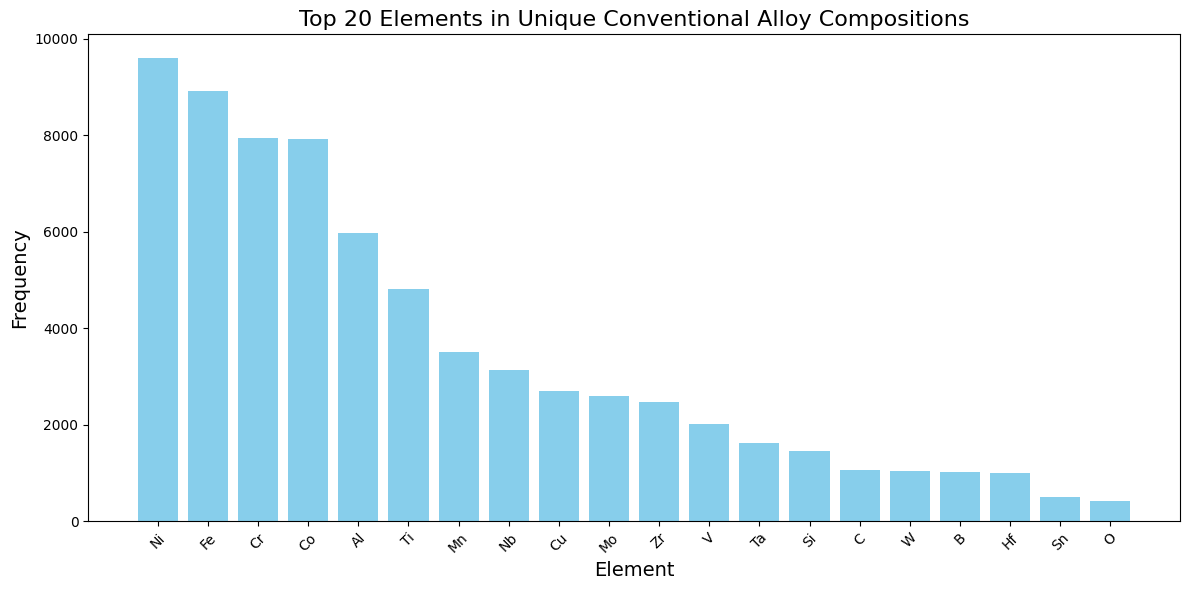

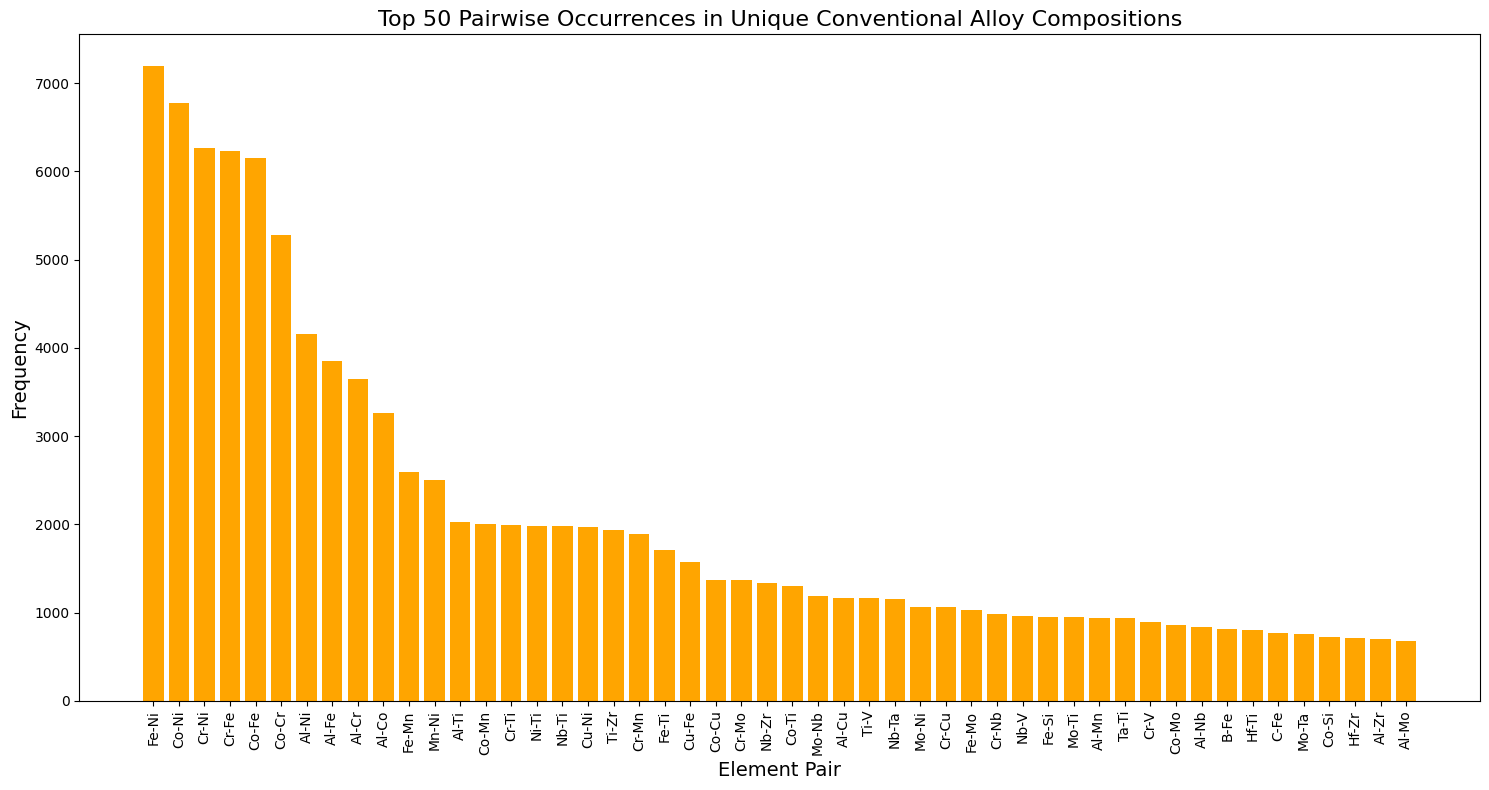

: 

In [ ]:
import pandas as pd
import re
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt

# Define non-radioactive elements
NON_RADIOACTIVE_ELEMENTS = [
    'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar',
    'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br',
    'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te',
    'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm',
    'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn',
    'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U'
]

# Function to extract valid elements from alloy name
def extract_elements(alloy_name):
    # Extract elements using regex
    elements = re.findall(r'[A-Z][a-z]?\d*\.?\d*', alloy_name)
    # Remove numeric parts to get the element symbols
    valid_elements = [re.sub(r'\d*\.?\d*', '', el) for el in elements]
    # Filter out invalid elements
    return [el for el in valid_elements if el in NON_RADIOACTIVE_ELEMENTS]

# Load the dataset
file_path = r".\final_query_set1_dois_results_dec_ver_all\cleaned_sorted_combined_results_with_doi.csv"
df = pd.read_csv(file_path)

# Filter for "conventional" and "alloy"
filtered_df = df[(df['Conventional'] == 'conventional') & (df['Type'] == 'alloy')]

# Drop duplicate alloy-DOI pairs to count each alloy composition only once per DOI
unique_compositions = filtered_df.drop_duplicates(subset=['Alloy Name'])

# Extract elements for each unique alloy name
unique_compositions['Elements'] = unique_compositions['Alloy Name'].apply(extract_elements)

# 1. Top 20 elements in the periodic table occurring in unique compositions
all_elements = [element for sublist in unique_compositions['Elements'] for element in sublist]
element_counts = Counter(all_elements)
top_20_elements = element_counts.most_common(20)

# Plot top 20 elements
elements, counts = zip(*top_20_elements)
plt.figure(figsize=(12, 6))
plt.bar(elements, counts, color='skyblue')
plt.title('Top 20 Elements in Unique Conventional Alloy Compositions', fontsize=16)
plt.xlabel('Element', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Top 50 pairwise occurrences of elements in unique compositions
pairwise_counts = Counter()
for elements in unique_compositions['Elements']:
    pairs = combinations(sorted(elements), 2)  # Create sorted pairs
    pairwise_counts.update(pairs)

top_50_pairs = pairwise_counts.most_common(50)

# Plot top 50 pairs
pairs, pair_counts = zip(*top_50_pairs)
pair_labels = [f"{pair[0]}-{pair[1]}" for pair in pairs]
plt.figure(figsize=(15, 8))
plt.bar(pair_labels, pair_counts, color='orange')
plt.title('Top 50 Pairwise Occurrences in Unique Conventional Alloy Compositions', fontsize=16)
plt.xlabel('Element Pair', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()


Total number of DOI counts: 10120


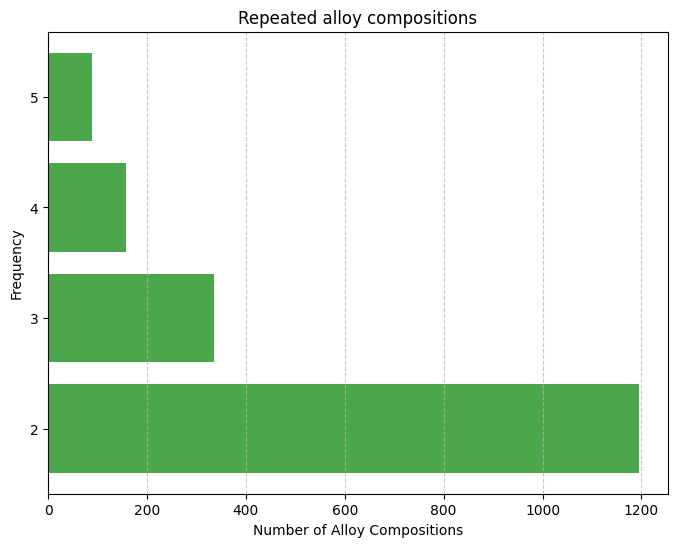

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
# Load the CSV file
file_path = r".\final_query_set1_dois_results_dec_ver_all\repeated_alloys.csv"
df = pd.read_csv(file_path)

# Compute the length of the DOI list
df['DOI_count'] = df['DOIs'].astype(str).apply(lambda x: len(x.split(',')) if x else 0)

# Count how many rows have each DOI list length
doi_length_counts = df['DOI_count'].value_counts().sort_index()

# Compute the sum of all DOI counts
total_doi_count = df['DOI_count'] .sum()
print(f"Total number of DOI counts: {total_doi_count}")

# Keep only lengths up to 5
doi_length_counts = doi_length_counts[doi_length_counts.index <= 5]


# Plot the horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(doi_length_counts.index.astype(str), doi_length_counts.values, color='green', alpha=0.7)
plt.ylabel('Frequency')
plt.xlabel('Number of Alloy Compositions')
plt.title('Repeated alloy compositions')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
